# Exploratory V2
- This notebook builds off of the analysis in the original exploratory.ipynb notebook, but utilizes a larger more robust data set (PLAYER_TOURNAMENT_RESULTS_V3)

In [20]:
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np

conn = sqlite3.connect('/Users/nickospelt/Documents/App_Projects/PGA_Score_Predictor/Data/PGA_SQL_DB/PGA.db')

## Correlation Between Weather and Golf Scores

### Pull Weather Data

In [2]:
weather_query = """WITH
    TOURNAMENT_ROUND_AVGS AS (
        SELECT TOURNAMENT_NAME, 
            AVG(R1_SCORE - PAR) AS R1_AVG_SCORE,
            AVG(R2_SCORE - PAR) AS R2_AVG_SCORE,
            AVG(R3_SCORE - PAR) AS R3_AVG_SCORE,
            AVG(R4_SCORE - PAR) AS R4_AVG_SCORE
        FROM PLAYER_TOURNAMENT_RESULTS_V3
        GROUP BY 1
    )

SELECT DISTINCT PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME,ELEVATION,
    R1_TEMP, R1_PRECIP, R1_WIND_SPEED, R1_WIND_DIRECT,
    R2_TEMP, R2_PRECIP, R2_WIND_SPEED, R2_WIND_DIRECT,
    R3_TEMP, R3_PRECIP, R3_WIND_SPEED, R3_WIND_DIRECT,
    R4_TEMP, R4_PRECIP, R4_WIND_SPEED, R4_WIND_DIRECT,
    R1_AVG_SCORE, R2_AVG_SCORE, R3_AVG_SCORE, R4_AVG_SCORE
FROM PLAYER_TOURNAMENT_RESULTS_V3
    INNER JOIN TOURNAMENT_ROUND_AVGS ON TOURNAMENT_ROUND_AVGS.TOURNAMENT_NAME = PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME
ORDER BY PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME"""

weather_df = pd.read_sql_query(weather_query, conn)
weather_df

,TOURNAMENT_NAME,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,R2_TEMP,R2_PRECIP,R2_WIND_SPEED,R2_WIND_DIRECT,...,R3_WIND_SPEED,R3_WIND_DIRECT,R4_TEMP,R4_PRECIP,R4_WIND_SPEED,R4_WIND_DIRECT,R1_AVG_SCORE,R2_AVG_SCORE,R3_AVG_SCORE,R4_AVG_SCORE
0,2017 PGA Championship,254.0,73.6,0.000,7.3,124,75.1,0.685,9.0,194,...,7.8,209,78.1,0.035,7.5,47,0.986301,0.328767,1.191781,0.835616
1,2017 RBC Canadian Open,95.0,70.4,0.276,7.9,224,68.4,0.000,10.7,31,...,11.4,11,75.2,0.000,10.5,333,-3.813333,-2.706667,-2.266667,-1.413333
2,2017 Sanderson Farms Championship,94.0,59.1,0.000,10.3,210,63.8,0.016,12.8,185,...,15.7,340,45.9,0.000,6.3,303,-2.208333,-1.388889,0.069444,0.277778
3,2017 THE PLAYERS Championship,6.0,78.9,0.000,9.1,245,79.1,0.000,14.5,254,...,11.5,214,72.6,0.031,14.8,21,-0.845070,-0.478873,1.323944,1.605634
4,2017 The Greenbrier Classic,564.0,72.9,0.181,10.2,264,74.5,0.055,10.8,281,...,13.1,282,70.1,0.000,6.9,278,-1.943662,-1.605634,0.098592,-0.859155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2024 The Genesis Invitational,106.0,51.8,0.000,7.1,266,55.0,0.000,8.7,352,...,5.9,68,54.8,0.055,5.6,119,-1.720000,-1.320000,-1.740000,-0.540000
70,2024 U.S. Open,165.0,76.2,0.004,8.4,117,77.5,0.016,8.5,157,...,8.1,13,79.8,0.004,8.6,104,1.222222,0.708333,3.138889,1.750000
71,2024 Valero Texas Open,201.0,68.4,0.000,11.1,247,70.2,0.000,17.1,179,...,18.6,158,72.5,0.008,14.1,65,-0.695122,-0.512195,0.414634,-1.317073
72,2024 Wells Fargo Championship,254.0,70.2,0.075,15.5,231,69.7,0.012,16.3,269,...,12.8,324,64.5,0.000,10.8,301,-0.060606,-0.121212,1.803030,1.287879


### View Relationship Between Different Metrics and Score to Par

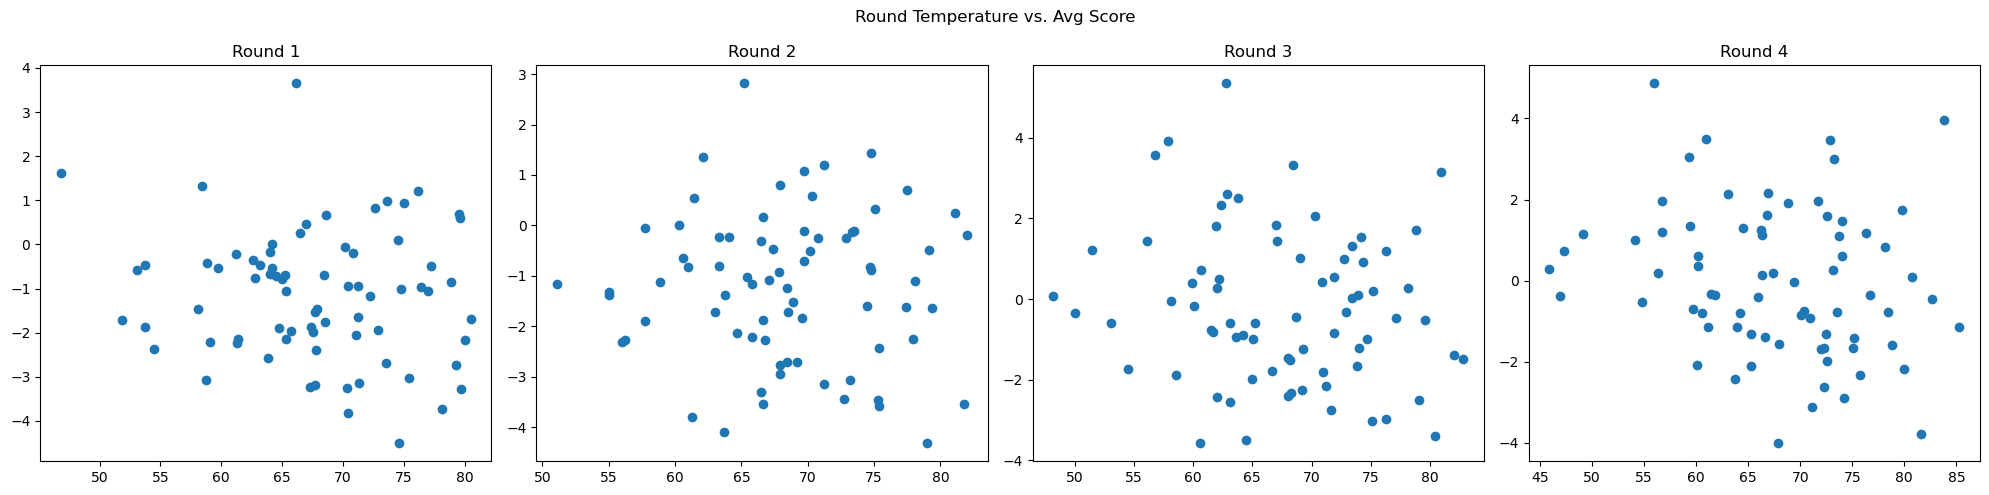

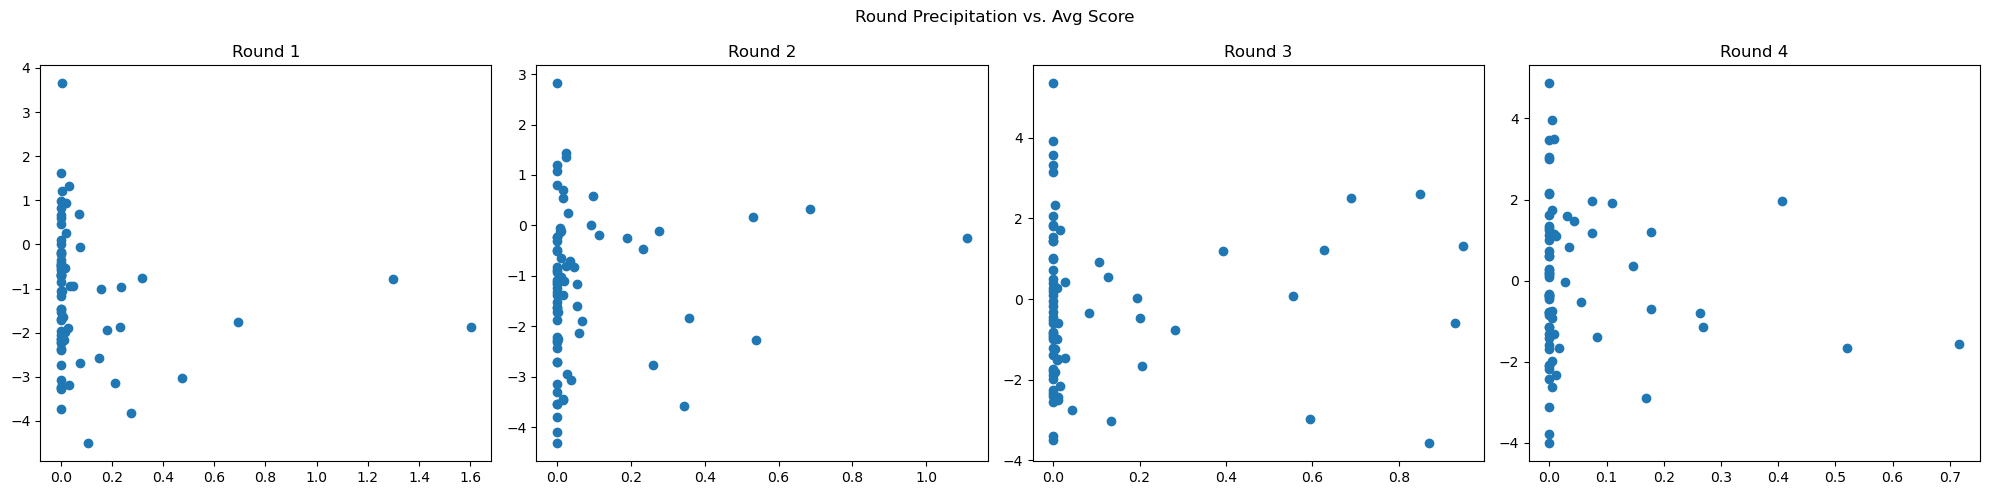

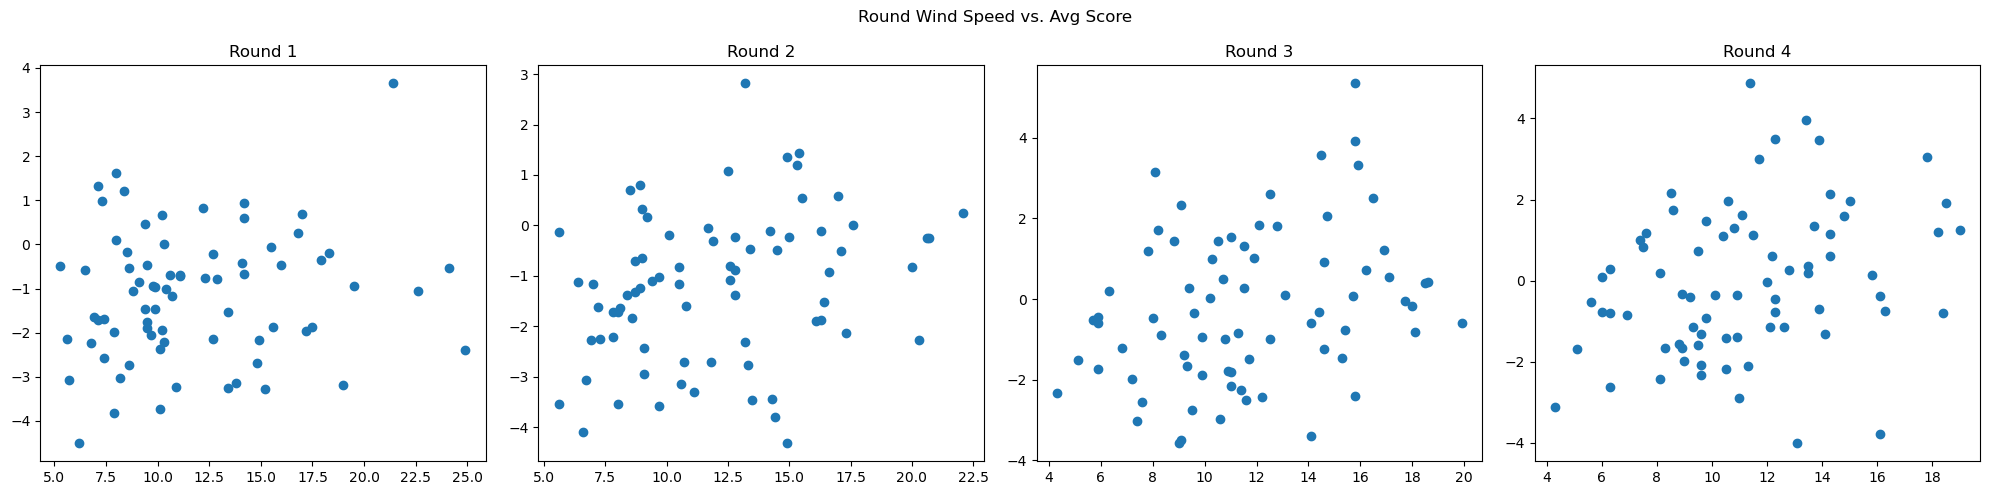

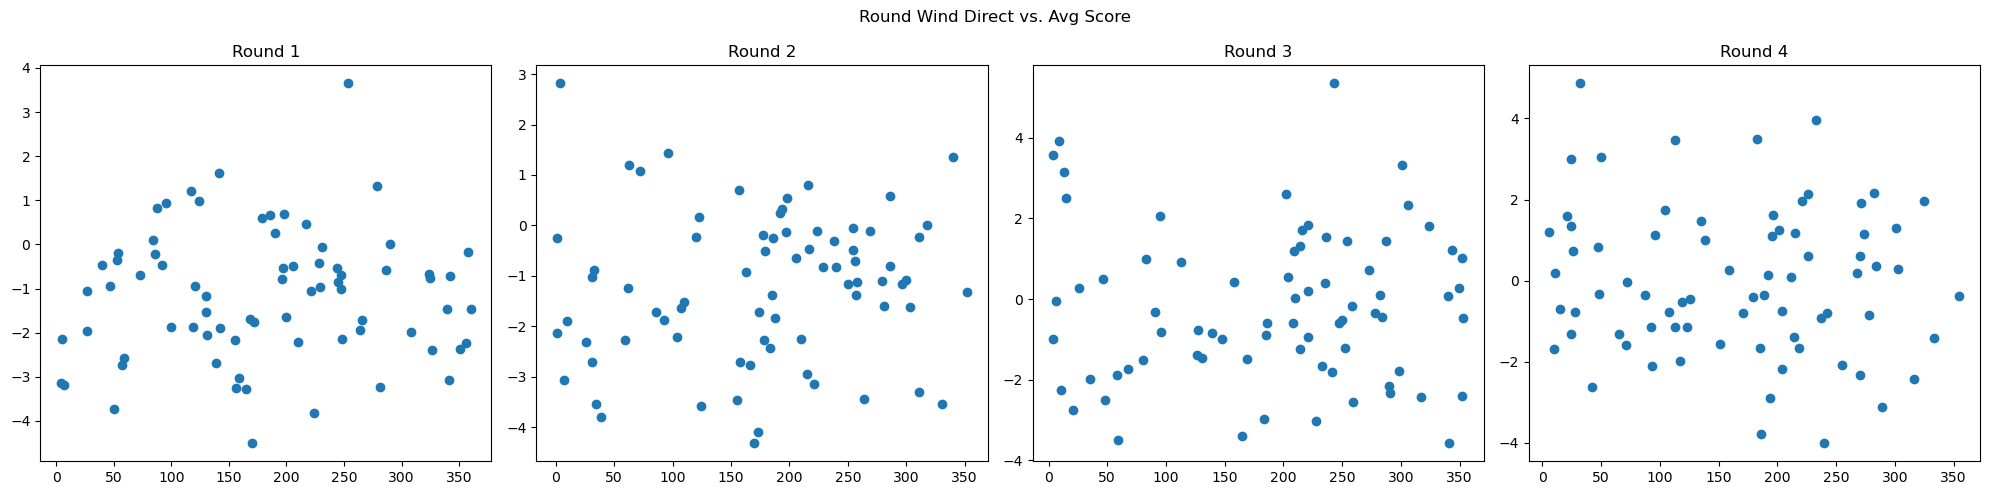

<Figure size 640x480 with 0 Axes>

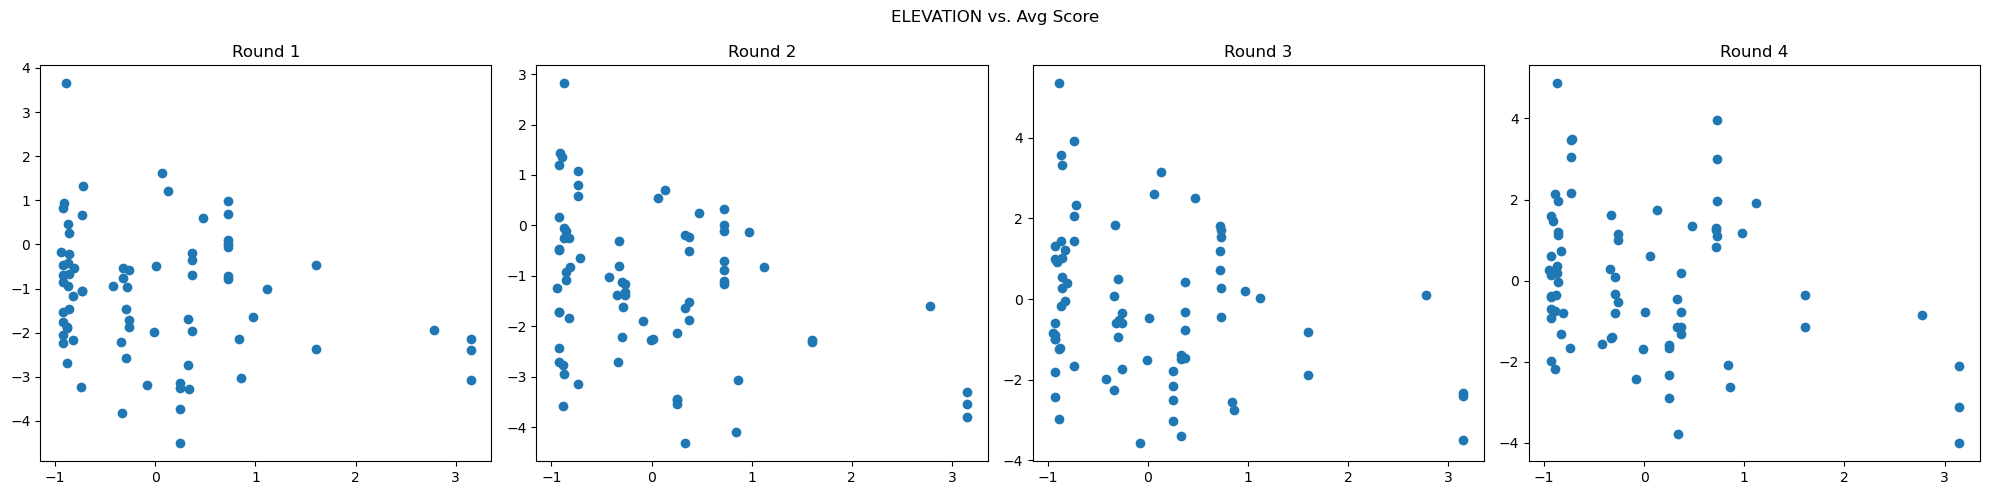

In [3]:
round_feature_mapping = {1: ['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT', 'ELEVATION', 'R1_AVG_SCORE'],
                        2: ['R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 'R2_WIND_DIRECT', 'ELEVATION', 'R2_AVG_SCORE'],
                        3: ['R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 'R3_WIND_DIRECT', 'ELEVATION', 'R3_AVG_SCORE'],
                        4: ['R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'R4_WIND_DIRECT', 'ELEVATION', 'R4_AVG_SCORE']}

scaler = StandardScaler()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Temperature vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][0]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Precipitation vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][1]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Wind Speed vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][2]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Wind Direct vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][3]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=((20,5)))
fig.suptitle('ELEVATION vs. Avg Score')
weather_df[['ELEVATION']] = scaler.fit_transform(weather_df[['ELEVATION']])
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][4]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][5]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

### Create an Aggregate Weather Feature to Summarize Weather Conditions

In [4]:
# Create weather feature (Weighted average of temp, precipiation, and wind speed)
def weather_weighted_average(temp, precip, wind_speed, elevation):
    weights = [0.1, 0.4, 0.2, 0.3]
    return (temp * -1 * weights[0] + elevation * -1 *weights[1] + precip * weights[2] + wind_speed * weights[3]) / (weights[0] + weights[1] + weights[2] + weights[3])

scaler = StandardScaler()
weather_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 'R2_WIND_DIRECT',
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 'R3_WIND_DIRECT', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'R4_WIND_DIRECT', 'ELEVATION']] = scaler.fit_transform(weather_df[['R1_TEMP', 'R1_PRECIP', 'R1_WIND_SPEED', 'R1_WIND_DIRECT',
'R2_TEMP', 'R2_PRECIP', 'R2_WIND_SPEED', 'R2_WIND_DIRECT', 
'R3_TEMP', 'R3_PRECIP', 'R3_WIND_SPEED', 'R3_WIND_DIRECT', 
'R4_TEMP', 'R4_PRECIP', 'R4_WIND_SPEED', 'R4_WIND_DIRECT', 'ELEVATION']])

weather_df['R1_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R1_TEMP'], row['R1_PRECIP'], row['R1_WIND_SPEED'], row['ELEVATION']), axis=1)
weather_df['R2_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R2_TEMP'], row['R2_PRECIP'], row['R2_WIND_SPEED'], row['ELEVATION']), axis=1)
weather_df['R3_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R3_TEMP'], row['R3_PRECIP'], row['R3_WIND_SPEED'], row['ELEVATION']), axis=1)
weather_df['R4_WEATHER_FACTOR'] = weather_df.apply(lambda row:
    weather_weighted_average(row['R4_TEMP'], row['R4_PRECIP'], row['R4_WIND_SPEED'], row['ELEVATION']), axis=1)

weather_df

,TOURNAMENT_NAME,ELEVATION,R1_TEMP,R1_PRECIP,R1_WIND_SPEED,R1_WIND_DIRECT,R2_TEMP,R2_PRECIP,R2_WIND_SPEED,R2_WIND_DIRECT,...,R4_WIND_SPEED,R4_WIND_DIRECT,R1_AVG_SCORE,R2_AVG_SCORE,R3_AVG_SCORE,R4_AVG_SCORE,R1_WEATHER_FACTOR,R2_WEATHER_FACTOR,R3_WEATHER_FACTOR,R4_WEATHER_FACTOR
0,2017 PGA Championship,0.720904,0.782085,-0.339723,-1.005710,-0.588138,0.967667,3.390345,-0.753489,0.180443,...,-1.079422,-1.219188,0.986301,0.328767,1.191781,0.835616,-0.736228,0.066894,-0.473422,-0.749088
1,2017 RBC Canadian Open,-0.334091,0.356147,0.738857,-0.871212,0.423301,-0.002152,-0.410447,-0.328617,-1.526623,...,-0.200685,1.764151,-3.813333,-2.706667,-2.266667,-1.413333,-0.015571,-0.046823,0.002443,-0.088696
2,2017 Sanderson Farms Championship,-0.340726,-1.147946,-0.339723,-0.333217,0.281699,-0.667997,-0.321669,0.196225,0.086188,...,-1.430917,1.451213,-2.208333,-1.388889,0.069444,0.277778,0.083175,0.197624,1.078073,-0.124531
3,2017 THE PLAYERS Championship,-0.924622,1.487545,-0.339723,-0.602215,0.635703,1.546663,-0.410447,0.621097,0.808811,...,1.058839,-1.490401,-0.845070,-0.478873,1.323944,1.605634,-0.027515,0.319422,0.979062,0.606033
4,2017 The Greenbrier Classic,2.777811,0.688911,0.367607,-0.355634,0.827876,0.880818,-0.105273,-0.303625,1.091577,...,-1.255170,1.190432,-1.943662,-1.605634,0.098592,-0.859155,-1.213185,-1.311348,-1.165329,-1.592261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2024 The Genesis Invitational,-0.261104,-2.119617,-0.339723,-1.050543,0.848105,-1.941789,-0.410447,-0.828467,1.835146,...,-1.635956,-0.468138,-1.720000,-1.320000,-1.740000,-0.540000,-0.066705,-0.032009,-0.282276,-0.227247
70,2024 U.S. Open,0.130372,1.128160,-0.324092,-0.759130,-0.658938,1.315065,-0.321669,-0.878452,-0.207050,...,-0.757218,-0.624607,1.222222,0.708333,3.138889,1.750000,-0.457522,-0.511525,-0.597876,-0.486719
71,2024 Valero Texas Open,0.369239,0.089936,-0.339723,-0.153886,0.655931,0.258397,-0.410447,1.270901,0.023352,...,0.853800,-1.031425,-0.695122,-0.512195,0.414634,-1.317073,-0.270800,0.125646,0.302130,-0.009974
72,2024 Wells Fargo Championship,0.720904,0.329526,-0.046631,0.832437,0.494101,0.186022,-0.343863,1.070961,0.965903,...,-0.112811,1.430350,-0.060606,-0.121212,1.803030,1.287879,-0.080909,-0.054448,-0.213951,-0.363608


#### View the relationship between new weather feature and score to par

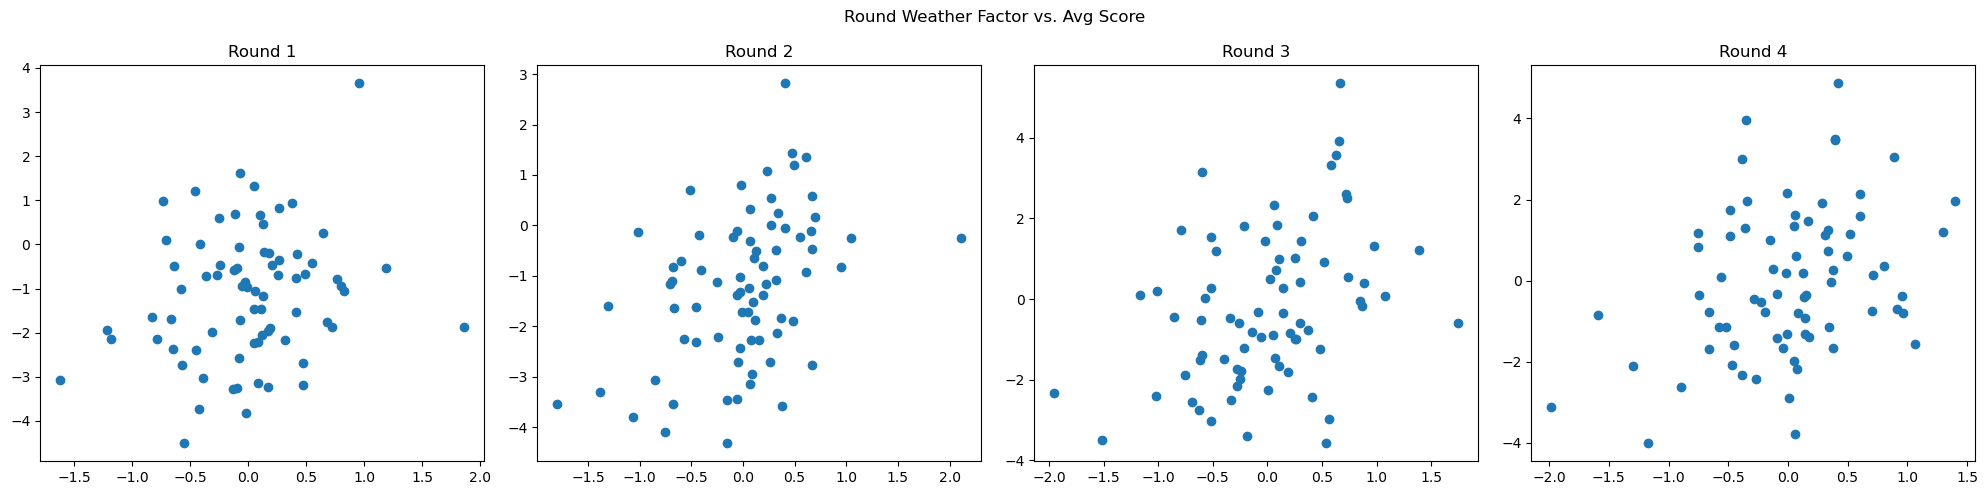

Round 1; Correlation: [0.2115861550049835], p-value: [0.07034318339582678]
Round 2; Correlation: [0.41809755372073903], p-value: [0.00020997859630996691]
Round 3; Correlation: [0.3658045174079986], p-value: [0.0013503504007818144]
Round 4; Correlation: [0.3455182516653974], p-value: [0.0025689051800810957]


In [5]:
# Vizualize relationship between weather factor and scrore to par
round_feature_mapping = {1: ['R1_WEATHER_FACTOR', 'R1_AVG_SCORE'],
                        2: ['R2_WEATHER_FACTOR', 'R2_AVG_SCORE'],
                        3: ['R3_WEATHER_FACTOR', 'R3_AVG_SCORE'],
                        4: ['R4_WEATHER_FACTOR', 'R4_AVG_SCORE']}

fig = plt.figure(figsize=((20,5)))
fig.suptitle('Round Weather Factor vs. Avg Score')
for key in round_feature_mapping:
    plt.subplot(1,4,key)
    plt.scatter(weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][0]].mean(), weather_df.groupby('TOURNAMENT_NAME')[round_feature_mapping[key][1]].mean())
    plt.title(f'Round {key}')

plt.tight_layout()
plt.show()

# Correlation between weather factor and score to par
r1_corr, r1_p_value = pearsonr(weather_df['R1_WEATHER_FACTOR'], weather_df['R1_AVG_SCORE'])
r2_corr, r2_p_value = pearsonr(weather_df['R2_WEATHER_FACTOR'], weather_df['R2_AVG_SCORE'])
r3_corr, r3_p_value = pearsonr(weather_df['R3_WEATHER_FACTOR'], weather_df['R3_AVG_SCORE'])
r4_corr, r4_p_value = pearsonr(weather_df['R4_WEATHER_FACTOR'], weather_df['R4_AVG_SCORE'])

print(f"Round 1; Correlation: [{r1_corr}], p-value: [{r1_p_value}]")
print(f"Round 2; Correlation: [{r2_corr}], p-value: [{r2_p_value}]")
print(f"Round 3; Correlation: [{r3_corr}], p-value: [{r3_p_value}]")
print(f"Round 4; Correlation: [{r4_corr}], p-value: [{r4_p_value}]")

- A larger weather factor for a round results in larger tournament scores to par (i.e. -10 means 10 under for the tournament).
- Significant increase from the correlation found in the initital exploratory results

## Correlation Between Historical Player Statistics and Score

### Pull Strokes Gained Putting Data

In [4]:
strokes_gained_query = """WITH TOURNAMENT_AVERAGES AS (
    SELECT TOURNAMENT_NAME,
        AVG(SG_PUTT) AS TOURN_AVG_SG_PUTT,
        AVG(SG_OFF_THE_TEE) AS TOURN_AVG_SG_OFF_THE_TEE,
        AVG(SG_APPROACH) AS TOURN_AVG_SG_APPROACH,
        AVG(SG_AROUND_THE_GREEN) AS TOURN_AVG_SG_AROUND_THE_GREEN,
        AVG(TOTAL_SCORE_TO_PAR) AS TOURN_AVG_TOTAL_SCORE_TO_PAR
    FROM PLAYER_TOURNAMENT_RESULTS_V3
    GROUP BY 1
)
     

SELECT PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME, TOURNAMENT_DATE, PLAYER_NAME, 
    SG_PUTT, TOURN_AVG_SG_PUTT, SG_PUTT - TOURN_AVG_SG_PUTT AS ADJ_SG_PUTT,
    SG_OFF_THE_TEE, TOURN_AVG_SG_OFF_THE_TEE, SG_OFF_THE_TEE - TOURN_AVG_SG_OFF_THE_TEE AS ADJ_SG_OFF_THE_TEE,
    SG_APPROACH, TOURN_AVG_SG_APPROACH, SG_APPROACH - TOURN_AVG_SG_APPROACH AS ADJ_SG_APPROACH,
    SG_AROUND_THE_GREEN, TOURN_AVG_SG_AROUND_THE_GREEN, SG_AROUND_THE_GREEN - TOURN_AVG_SG_AROUND_THE_GREEN AS ADJ_SG_AROUND_THE_GREEN, 
    R1_SCORE - PAR AS R1_SCORE_TO_PAR,
    R2_SCORE - PAR AS R2_SCORE_TO_PAR,
    R3_SCORE - PAR AS R3_SCORE_TO_PAR,
    R4_SCORE - PAR AS R4_SCORE_TO_PAR,
    TOTAL_SCORE_TO_PAR, TOURN_AVG_TOTAL_SCORE_TO_PAR, TOTAL_SCORE_TO_PAR - TOURN_AVG_TOTAL_SCORE_TO_PAR AS ADJ_TOT_SCORE_TO_PAR
FROM PLAYER_TOURNAMENT_RESULTS_V3
INNER JOIN TOURNAMENT_AVERAGES ON PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_NAME = TOURNAMENT_AVERAGES.TOURNAMENT_NAME
ORDER BY PLAYER_NAME, PLAYER_TOURNAMENT_RESULTS_V3.TOURNAMENT_DATE"""

strokes_gained_df = pd.read_sql_query(strokes_gained_query, conn)
strokes_gained_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,SG_PUTT,TOURN_AVG_SG_PUTT,ADJ_SG_PUTT,SG_OFF_THE_TEE,TOURN_AVG_SG_OFF_THE_TEE,ADJ_SG_OFF_THE_TEE,SG_APPROACH,...,SG_AROUND_THE_GREEN,TOURN_AVG_SG_AROUND_THE_GREEN,ADJ_SG_AROUND_THE_GREEN,R1_SCORE_TO_PAR,R2_SCORE_TO_PAR,R3_SCORE_TO_PAR,R4_SCORE_TO_PAR,TOTAL_SCORE_TO_PAR,TOURN_AVG_TOTAL_SCORE_TO_PAR,ADJ_TOT_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,1.19375,0.314958,0.878792,-1.464,0.193352,-1.657352,1.030,...,-0.099,0.111268,-0.210268,-2,1,4,0,3,1.605634,1.394366
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,0.49900,0.265542,0.233458,0.087,0.084347,0.002653,-0.090,...,0.417,0.175694,0.241306,-3,-4,2,1,-4,-3.250000,-0.750000
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,-0.28450,0.406461,-0.690961,0.078,0.115676,-0.037676,0.953,...,1.162,0.204113,0.957887,-1,-1,-4,-1,-7,-3.338028,-3.661972
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,0.02150,0.400420,-0.378920,0.147,0.084773,0.062227,1.256,...,-0.029,0.259758,-0.288758,4,2,7,-1,12,12.500000,-0.500000
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,1.05650,0.293667,0.762833,0.177,0.136847,0.040153,-1.447,...,0.491,0.122611,0.368389,-2,0,0,2,0,-2.236111,2.236111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,-0.11850,0.389971,-0.508471,0.130,0.120681,0.009319,-1.194,...,-0.039,0.088203,-0.127203,-3,-3,2,1,-3,-11.347826,8.347826
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,-0.00500,0.406461,-0.411461,0.676,0.115676,0.560324,-0.515,...,0.002,0.204113,-0.202113,-1,-1,1,1,0,-3.338028,3.338028
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,-1.66275,0.266493,-1.929243,0.271,0.105284,0.165716,-1.414,...,0.209,0.179104,0.029896,-3,2,6,8,13,-1.074627,14.074627
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,0.15875,0.279135,-0.120385,0.007,0.174375,-0.167375,-0.559,...,-0.687,0.105861,-0.792861,0,-2,1,9,8,0.611111,7.388889


### Historicallly Weighted Averages based on Different Half Life Values

In [6]:
def convert_string_to_date(date_string):
    return datetime.strptime(date_string, "%Y-%m-%d")

def compute_days_between(date_one, date_two):
    duration = date_two - date_one
    return duration.days

def compute_half_life_weight(half_life, days):
    return np.power(0.5, (days / half_life))

# for each row, need to look at all previous tournaments for that player. and calculate weights based on the different between that rows tournament date and the other rows tournament weight.
def calc_weighted_avgs(df, player_name, tournament_date, features):
    prev_rounds_df = df.copy()
    tournament_date = convert_string_to_date(tournament_date)
    prev_rounds_df.loc[:, 'TOURNAMENT_DATE'] = prev_rounds_df.apply(lambda row: convert_string_to_date(row['TOURNAMENT_DATE']), axis=1)
    prev_rounds_df = prev_rounds_df.loc[(prev_rounds_df['PLAYER_NAME'] == player_name) & (prev_rounds_df['TOURNAMENT_DATE'] < tournament_date)].sort_values(by='TOURNAMENT_DATE', ascending=False)

    if prev_rounds_df.shape[0] == 0:
        return None

    # Retrieve the 3 most recent tournaments
    prev_3_rounds_df = prev_rounds_df.head(3)

    # Weighting by how recent data is
    prev_rounds_df['DAYS_SINCE'] = prev_rounds_df.apply(lambda row: compute_days_between(row['TOURNAMENT_DATE'], tournament_date), axis=1)
    prev_rounds_df['HL_50_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(50, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_100_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(100, row['DAYS_SINCE']), axis=1)
    prev_rounds_df['HL_200_WEIGHT'] = prev_rounds_df.apply(lambda row: compute_half_life_weight(200, row['DAYS_SINCE']), axis=1)

    weight_sum_HL_50 = prev_rounds_df['HL_50_WEIGHT'].sum()
    weight_sum_HL_100 = prev_rounds_df['HL_100_WEIGHT'].sum()
    weight_sum_HL_200 = prev_rounds_df['HL_200_WEIGHT'].sum()
    
    # SG_PUTT
    PREV_SG_P = prev_rounds_df[features[0]].iloc[0]
    PREV_3_AVG_SG_P = prev_3_rounds_df[features[0]].mean()

    prev_rounds_df['HL_50_SG_P'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[0]]
    prev_rounds_df['HL_100_SG_P'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[0]]
    prev_rounds_df['HL_200_SG_P'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[0]]

    HL_50_SG_P = prev_rounds_df['HL_50_SG_P'].sum() / weight_sum_HL_50
    HL_100_SG_P = prev_rounds_df['HL_100_SG_P'].sum() / weight_sum_HL_100
    HL_200_SG_P = prev_rounds_df['HL_200_SG_P'].sum() / weight_sum_HL_200

    # SG_OFF_THE_TEE
    PREV_SG_OTT = prev_rounds_df[features[1]].iloc[0]
    PREV_3_AVG_SG_OTT = prev_3_rounds_df[features[1]].mean()

    prev_rounds_df['HL_50_SG_OTT'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[1]]
    prev_rounds_df['HL_100_SG_OTT'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[1]]
    prev_rounds_df['HL_200_SG_OTT'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[1]]

    HL_50_SG_OTT = prev_rounds_df['HL_50_SG_OTT'].sum() / weight_sum_HL_50
    HL_100_SG_OTT = prev_rounds_df['HL_100_SG_OTT'].sum() / weight_sum_HL_100
    HL_200_SG_OTT = prev_rounds_df['HL_200_SG_OTT'].sum() / weight_sum_HL_200

    # SG_APPROACH
    PREV_SG_APR = prev_rounds_df[features[2]].iloc[0]
    PREV_3_AVG_SG_APR = prev_3_rounds_df[features[2]].mean()

    prev_rounds_df['HL_50_SG_APR'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[2]]
    prev_rounds_df['HL_100_SG_APR'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[2]]
    prev_rounds_df['HL_200_SG_APR'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[2]]

    HL_50_SG_APR = prev_rounds_df['HL_50_SG_APR'].sum() / weight_sum_HL_50
    HL_100_SG_APR = prev_rounds_df['HL_100_SG_APR'].sum() / weight_sum_HL_100
    HL_200_SG_APR = prev_rounds_df['HL_200_SG_APR'].sum() / weight_sum_HL_200

    # SG_AROUND_THE_GREEN
    PREV_SG_ATG = prev_rounds_df[features[3]].iloc[0]
    PREV_3_AVG_SG_ATG = prev_3_rounds_df[features[3]].mean()

    prev_rounds_df['HL_50_SG_ATG'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[3]]
    prev_rounds_df['HL_100_SG_ATG'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[3]]
    prev_rounds_df['HL_200_SG_ATG'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[3]]

    HL_50_SG_ATG = prev_rounds_df['HL_50_SG_ATG'].sum() / weight_sum_HL_50
    HL_100_SG_ATG = prev_rounds_df['HL_100_SG_ATG'].sum() / weight_sum_HL_100
    HL_200_SG_ATG = prev_rounds_df['HL_200_SG_ATG'].sum() / weight_sum_HL_200

    # TOTAL_SCORE_TO_PAR
    PREV_TOT_SCORE_TO_PAR = prev_rounds_df[features[4]].iloc[0]
    PREV_3_AVG_TOT_SCORE_TO_PAR = prev_3_rounds_df[features[4]].mean()

    prev_rounds_df['HL_50_TOT_SCORE_TO_PAR'] = prev_rounds_df['HL_50_WEIGHT'] * prev_rounds_df[features[4]]
    prev_rounds_df['HL_100_TOT_SCORE_TO_PAR'] = prev_rounds_df['HL_100_WEIGHT'] * prev_rounds_df[features[4]]
    prev_rounds_df['HL_200_TOT_SCORE_TO_PAR'] = prev_rounds_df['HL_200_WEIGHT'] * prev_rounds_df[features[4]]

    HL_50_TOT_SCORE_TO_PAR = prev_rounds_df['HL_50_TOT_SCORE_TO_PAR'].sum() / weight_sum_HL_50
    HL_100_TOT_SCORE_TO_PAR = prev_rounds_df['HL_100_TOT_SCORE_TO_PAR'].sum() / weight_sum_HL_100
    HL_200_TOT_SCORE_TO_PAR = prev_rounds_df['HL_200_TOT_SCORE_TO_PAR'].sum() / weight_sum_HL_200

    return PREV_SG_P, PREV_3_AVG_SG_P, HL_50_SG_P, HL_100_SG_P, HL_200_SG_P, PREV_SG_OTT, PREV_3_AVG_SG_OTT, HL_50_SG_OTT, HL_100_SG_OTT, HL_200_SG_OTT, PREV_SG_APR, PREV_3_AVG_SG_APR, HL_50_SG_APR, HL_100_SG_APR, HL_200_SG_APR, PREV_SG_ATG, PREV_3_AVG_SG_ATG, HL_50_SG_ATG, HL_100_SG_ATG, HL_200_SG_ATG, PREV_TOT_SCORE_TO_PAR, PREV_3_AVG_TOT_SCORE_TO_PAR, HL_50_TOT_SCORE_TO_PAR, HL_100_TOT_SCORE_TO_PAR, HL_200_TOT_SCORE_TO_PAR

# Apply the relevant half life values for each of the factors based on the half-life values from the research paper
strokes_gained_df[['PREV_SG_P', 'PREV_3_AVG_SG_P', 'HL_50_SG_P', 'HL_100_SG_P', 'HL_200_SG_P', 
    'PREV_SG_OTT', 'PREV_3_AVG_SG_OTT', 'HL_50_SG_OTT', 'HL_100_SG_OTT', 'HL_200_SG_OTT',
    'PREV_SG_APR', 'PREV_3_AVG_SG_APR', 'HL_50_SG_APR', 'HL_100_SG_APR', 'HL_200_SG_APR',
    'PREV_SG_ATG', 'PREV_3_AVG_SG_ATG', 'HL_50_SG_ATG', 'HL_100_SG_ATG', 'HL_200_SG_ATG',
    'PREV_TOT_SCORE_TO_PAR', 'PREV_3_AVG_TOT_SCORE_TO_PAR', 'HL_50_TOT_SCORE_TO_PAR', 'HL_100_TOT_SCORE_TO_PAR', 'HL_200_TOT_SCORE_TO_PAR']] = strokes_gained_df.apply(
        lambda row: pd.Series(calc_weighted_avgs(strokes_gained_df, row['PLAYER_NAME'], row['TOURNAMENT_DATE'], ["ADJ_SG_PUTT", "ADJ_SG_OFF_THE_TEE", "ADJ_SG_APPROACH", "ADJ_SG_AROUND_THE_GREEN", "TOTAL_SCORE_TO_PAR"])), axis=1)
strokes_gained_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,SG_PUTT,TOURN_AVG_SG_PUTT,ADJ_SG_PUTT,SG_OFF_THE_TEE,TOURN_AVG_SG_OFF_THE_TEE,ADJ_SG_OFF_THE_TEE,SG_APPROACH,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
0,2017 THE PLAYERS Championship,2017-05-11,Aaron Baddeley,1.19375,0.314958,0.878792,-1.464,0.193352,-1.657352,1.030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,0.49900,0.265542,0.233458,0.087,0.084347,0.002653,-0.090,...,-0.210268,-0.210268,-0.210268,-0.210268,-0.210268,3.0,3.000000,3.000000,3.000000,3.000000
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,-0.28450,0.406461,-0.690961,0.078,0.115676,-0.037676,0.953,...,0.241306,0.015519,0.201228,0.133898,0.079454,-4.0,-0.500000,-3.378739,-2.335030,-1.491085
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,0.02150,0.400420,-0.378920,0.147,0.084773,0.062227,1.256,...,0.957887,0.329642,0.890983,0.726660,0.554320,-7.0,-2.666667,-6.679806,-5.690919,-4.469108
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,1.05650,0.293667,0.762833,0.177,0.136847,0.040153,-1.447,...,-0.288758,0.303478,0.106957,0.204029,0.220233,12.0,0.333333,5.734322,3.414513,2.057123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,-0.11850,0.389971,-0.508471,0.130,0.120681,0.009319,-1.194,...,0.071125,-0.193099,-0.095396,-0.142453,-0.167539,-7.0,-8.500000,-7.945338,-8.212479,-8.354894
5288,2018 Valero Texas Open,2018-04-19,Zecheng Dou,-0.00500,0.406461,-0.411461,0.676,0.115676,0.560324,-0.515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,-1.66275,0.266493,-1.929243,0.271,0.105284,0.165716,-1.414,...,-0.202113,-0.202113,-0.202113,-0.202113,-0.202113,0.0,0.000000,0.000000,0.000000,0.000000
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,0.15875,0.279135,-0.120385,0.007,0.174375,-0.167375,-0.559,...,0.029896,-0.086109,0.029896,0.029893,0.029177,13.0,6.500000,13.000000,12.999874,12.959727


In [7]:
no_na_strokes_gained_df = strokes_gained_df.dropna()
no_na_strokes_gained_df

,TOURNAMENT_NAME,TOURNAMENT_DATE,PLAYER_NAME,SG_PUTT,TOURN_AVG_SG_PUTT,ADJ_SG_PUTT,SG_OFF_THE_TEE,TOURN_AVG_SG_OFF_THE_TEE,ADJ_SG_OFF_THE_TEE,SG_APPROACH,...,PREV_SG_ATG,PREV_3_AVG_SG_ATG,HL_50_SG_ATG,HL_100_SG_ATG,HL_200_SG_ATG,PREV_TOT_SCORE_TO_PAR,PREV_3_AVG_TOT_SCORE_TO_PAR,HL_50_TOT_SCORE_TO_PAR,HL_100_TOT_SCORE_TO_PAR,HL_200_TOT_SCORE_TO_PAR
1,2017 Sanderson Farms Championship,2017-10-26,Aaron Baddeley,0.49900,0.265542,0.233458,0.087,0.084347,0.002653,-0.090,...,-0.210268,-0.210268,-0.210268,-0.210268,-0.210268,3.0,3.000000,3.000000,3.000000,3.000000
2,2018 Valero Texas Open,2018-04-19,Aaron Baddeley,-0.28450,0.406461,-0.690961,0.078,0.115676,-0.037676,0.953,...,0.241306,0.015519,0.201228,0.133898,0.079454,-4.0,-0.500000,-3.378739,-2.335030,-1.491085
3,2018 U.S. Open,2018-06-14,Aaron Baddeley,0.02150,0.400420,-0.378920,0.147,0.084773,0.062227,1.256,...,0.957887,0.329642,0.890983,0.726660,0.554320,-7.0,-2.666667,-6.679806,-5.690919,-4.469108
4,2019 Genesis Open,2019-02-14,Aaron Baddeley,1.05650,0.293667,0.762833,0.177,0.136847,0.040153,-1.447,...,-0.288758,0.303478,0.106957,0.204029,0.220233,12.0,0.333333,5.734322,3.414513,2.057123
5,2020 Waste Management Phoenix Open,2020-01-30,Aaron Baddeley,-0.37000,0.377659,-0.747659,-0.091,0.171167,-0.262167,-0.492,...,0.368389,0.345840,0.355846,0.325277,0.291477,0.0,1.666667,0.275130,0.895639,1.067911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5286,2019 3M Open,2019-07-04,Zack Sucher,0.26650,0.264826,0.001674,-0.216,0.207556,-0.423556,-0.240,...,-0.457324,-0.457324,-0.457324,-0.457324,-0.457324,-10.0,-10.000000,-10.000000,-10.000000,-10.000000
5287,2020 Rocket Mortgage Classic,2020-07-02,Zack Sucher,-0.11850,0.389971,-0.508471,0.130,0.120681,0.009319,-1.194,...,0.071125,-0.193099,-0.095396,-0.142453,-0.167539,-7.0,-8.500000,-7.945338,-8.212479,-8.354894
5289,2022 Cadence Bank Houston Open,2022-11-10,Zecheng Dou,-1.66275,0.266493,-1.929243,0.271,0.105284,0.165716,-1.414,...,-0.202113,-0.202113,-0.202113,-0.202113,-0.202113,0.0,0.000000,0.000000,0.000000,0.000000
5290,2023 Valspar Championship,2023-03-16,Zecheng Dou,0.15875,0.279135,-0.120385,0.007,0.174375,-0.167375,-0.559,...,0.029896,-0.086109,0.029896,0.029893,0.029177,13.0,6.500000,13.000000,12.999874,12.959727


### Relationship between Adjusted Metrics and Round/Tournament Score

In [60]:
features = ["ADJ_SG_PUTT", "ADJ_SG_OFF_THE_TEE", "ADJ_SG_APPROACH", "ADJ_SG_AROUND_THE_GREEN"]
targets = ['R1_SCORE_TO_PAR', 'R2_SCORE_TO_PAR', 'R3_SCORE_TO_PAR', 'R4_SCORE_TO_PAR', 'TOTAL_SCORE_TO_PAR']

for feature in features:
    print(feature)
    #fig = plt.figure(figsize=((20,5)))
    #fig.suptitle(f'{feature} vs. Scores to Par')
    #subplot = 1
    for target in targets:
        #plt.subplot(1,5,subplot)
        #plt.scatter(no_na_strokes_gained_df[feature], no_na_strokes_gained_df[target])
        #plt.xlabel(feature)
        #plt.ylabel(target)
        #plt.title(f'{round_feature_mapping[key][0]}')

        corr, p_value = pearsonr(no_na_strokes_gained_df[feature], no_na_strokes_gained_df[target])
        mutual_info = mutual_info_regression(no_na_strokes_gained_df[[feature]], no_na_strokes_gained_df[target])
        print(f"{target}; Correlation: [{corr}], p-value: [{p_value}], Mutual Information: [{mutual_info}]")

        #subplot += 1

    print("\n")
    #plt.tight_layout()
    #plt.show()

ADJ_SG_PUTT
R1_SCORE_TO_PAR; Correlation: [-0.14133889610473852], p-value: [1.6740980793021275e-22], Mutual Information: [[0.01511806]]
R2_SCORE_TO_PAR; Correlation: [-0.1339578233219247], p-value: [2.3438762559222382e-20], Mutual Information: [[0]]
R3_SCORE_TO_PAR; Correlation: [-0.2306616860592241], p-value: [4.494578866426934e-58], Mutual Information: [[0.02225042]]
R4_SCORE_TO_PAR; Correlation: [-0.24483334860996014], p-value: [2.016774204252485e-65], Mutual Information: [[0.03161973]]
TOTAL_SCORE_TO_PAR; Correlation: [-0.2985824493577245], p-value: [7.270361131848668e-98], Mutual Information: [[0.03461426]]


ADJ_SG_OFF_THE_TEE
R1_SCORE_TO_PAR; Correlation: [-0.13272582641168348], p-value: [5.209203446456265e-20], Mutual Information: [[0]]
R2_SCORE_TO_PAR; Correlation: [-0.11608172151005253], p-value: [1.2185444597816126e-15], Mutual Information: [[0.00068144]]
R3_SCORE_TO_PAR; Correlation: [-0.19452726245698448], p-value: [1.69023527973132e-41], Mutual Information: [[0.00465669]]

- Based on correlation I would rank the importance from greatest to smallest:
1. ADJ_SG_APPROACH
2. ADJ_SG_PUTT
3. ADJ_SG_OFF_THE_TEE
4. ADJ_SG_AROUND_THE_GREEN

### Historically Weighted Strokes gained

In [62]:
features = {"ADJ_SG_PUTT": ['HL_50_SG_P', 'HL_100_SG_P', 'HL_200_SG_P'], 
            "ADJ_SG_OFF_THE_TEE": ['HL_50_SG_OTT', 'HL_100_SG_OTT', 'HL_200_SG_OTT'], 
            "ADJ_SG_APPROACH": ['HL_50_SG_APR', 'HL_100_SG_APR', 'HL_200_SG_APR'], 
            "ADJ_SG_AROUND_THE_GREEN": [ 'HL_50_SG_ATG', 'HL_100_SG_ATG', 'HL_200_SG_ATG']}

targets = ['R1_SCORE_TO_PAR', 'R2_SCORE_TO_PAR', 'R3_SCORE_TO_PAR', 'R4_SCORE_TO_PAR', 'TOTAL_SCORE_TO_PAR']

for key in features:
    print(key)
    for target in targets:
        print(target)
        for half_life in features[key]:
            corr, p_value = pearsonr(no_na_strokes_gained_df[half_life], no_na_strokes_gained_df[target])
            mutual_info = mutual_info_regression(no_na_strokes_gained_df[[half_life]], no_na_strokes_gained_df[target])
            print(f"{half_life}; Correlation: [{corr}], p-value: [{p_value}], Mutual Information: [{mutual_info}]")

    print("\n")

ADJ_SG_PUTT
R1_SCORE_TO_PAR
HL_50_SG_P; Correlation: [0.007983747902439251], p-value: [0.5833216605315604], Mutual Information: [[0.00648461]]
HL_100_SG_P; Correlation: [0.0094700164552164], p-value: [0.5152656369255763], Mutual Information: [[0]]
HL_200_SG_P; Correlation: [0.010468796520484474], p-value: [0.47196364541455166], Mutual Information: [[0.03158843]]
R2_SCORE_TO_PAR
HL_50_SG_P; Correlation: [-0.0076573575843825546], p-value: [0.5988094746705283], Mutual Information: [[0]]
HL_100_SG_P; Correlation: [-0.009266720455438002], p-value: [0.5243254901334683], Mutual Information: [[0.00802657]]
HL_200_SG_P; Correlation: [-0.006884367877168311], p-value: [0.6362115653380248], Mutual Information: [[0]]
R3_SCORE_TO_PAR
HL_50_SG_P; Correlation: [0.016146702640211626], p-value: [0.2672378371257714], Mutual Information: [[0]]
HL_100_SG_P; Correlation: [0.013709096063990435], p-value: [0.3462233714059526], Mutual Information: [[0.01108081]]
HL_200_SG_P; Correlation: [0.012024593909945031]

- Not much is gained from this analysis. Correlations are weak and most p-values are above 0.05 threshold.
- Trying to get a sense for each feature which half-life should be used
- Idea is to pick the half-life with the greatest correlation for each feature/target combination
- SG_Putt: 200
- SG_OFF_THE_TEE: 200
- SG_APPROACH: 200
- SG_AROUND_THE_GREEN: 50

### Metrics of Individual Players Over Time
- Develop a better idea of how this value changes over time to engineer best feature to use for prediction

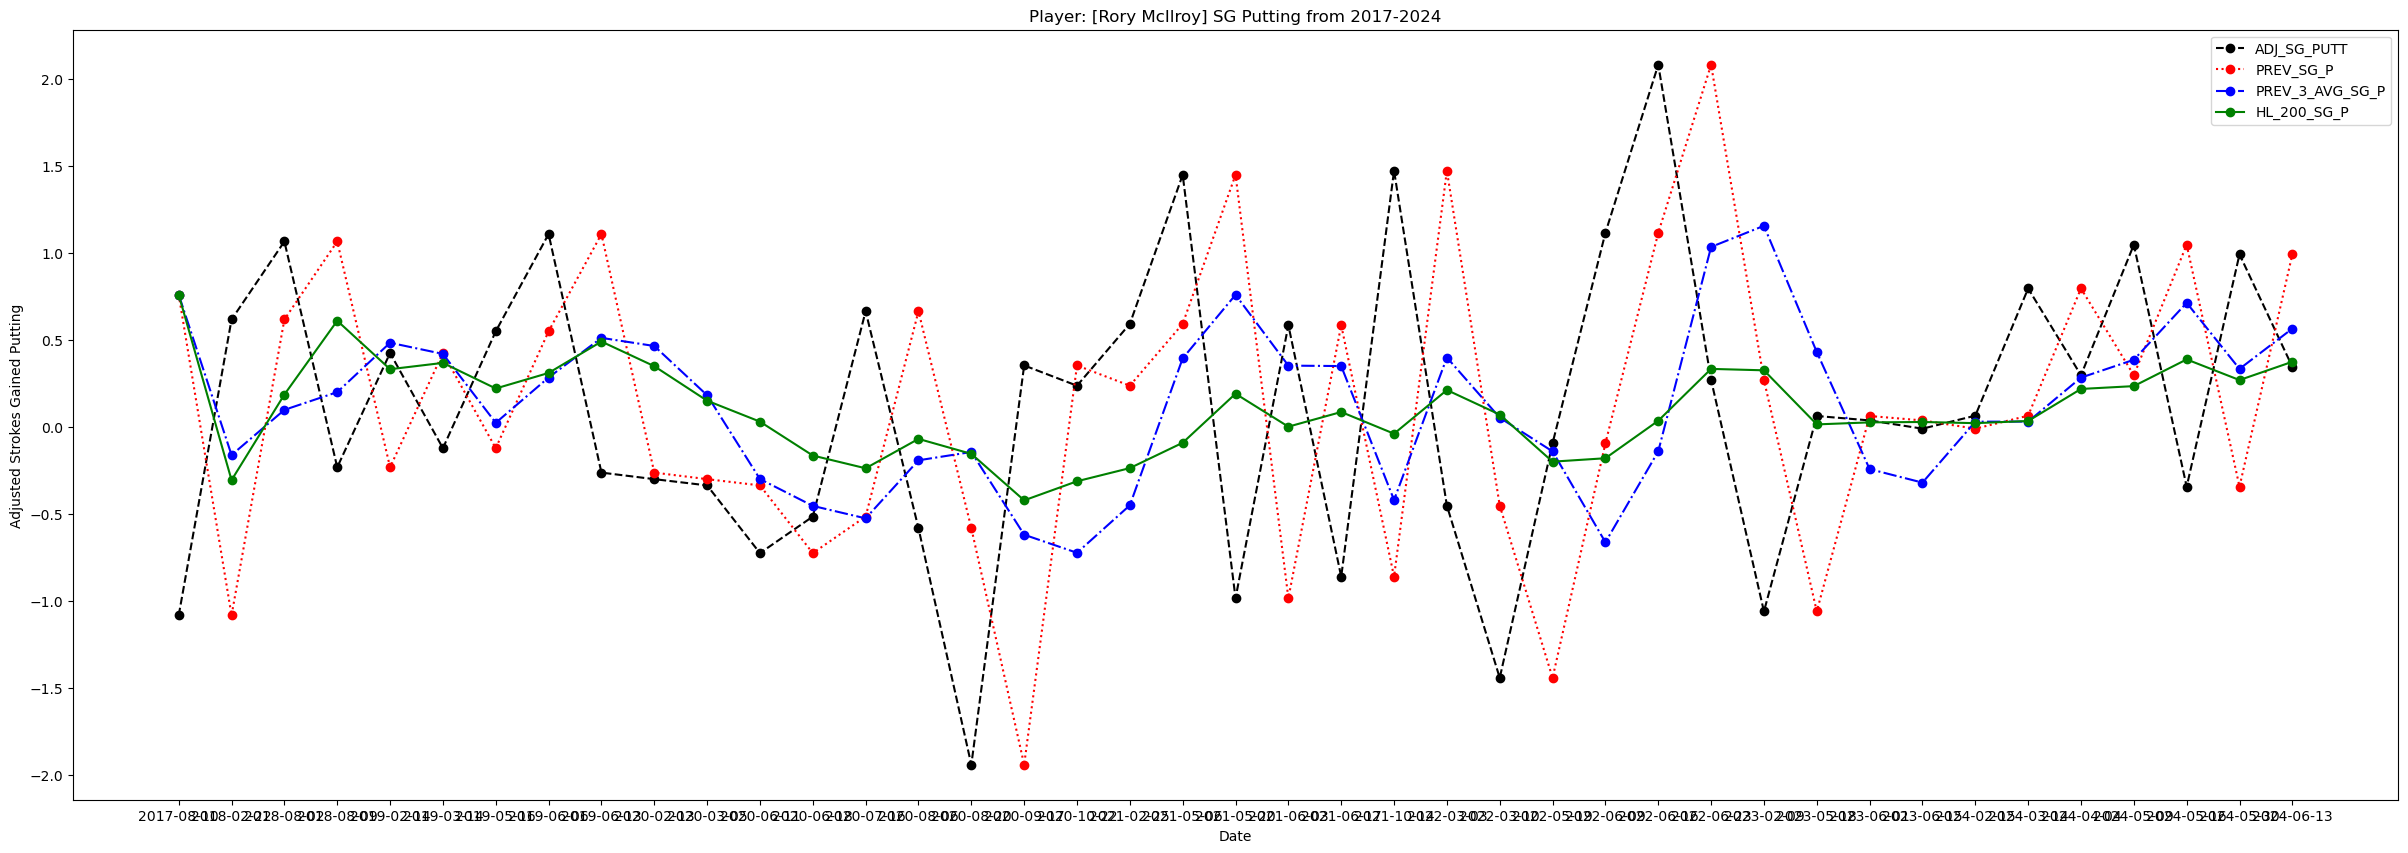

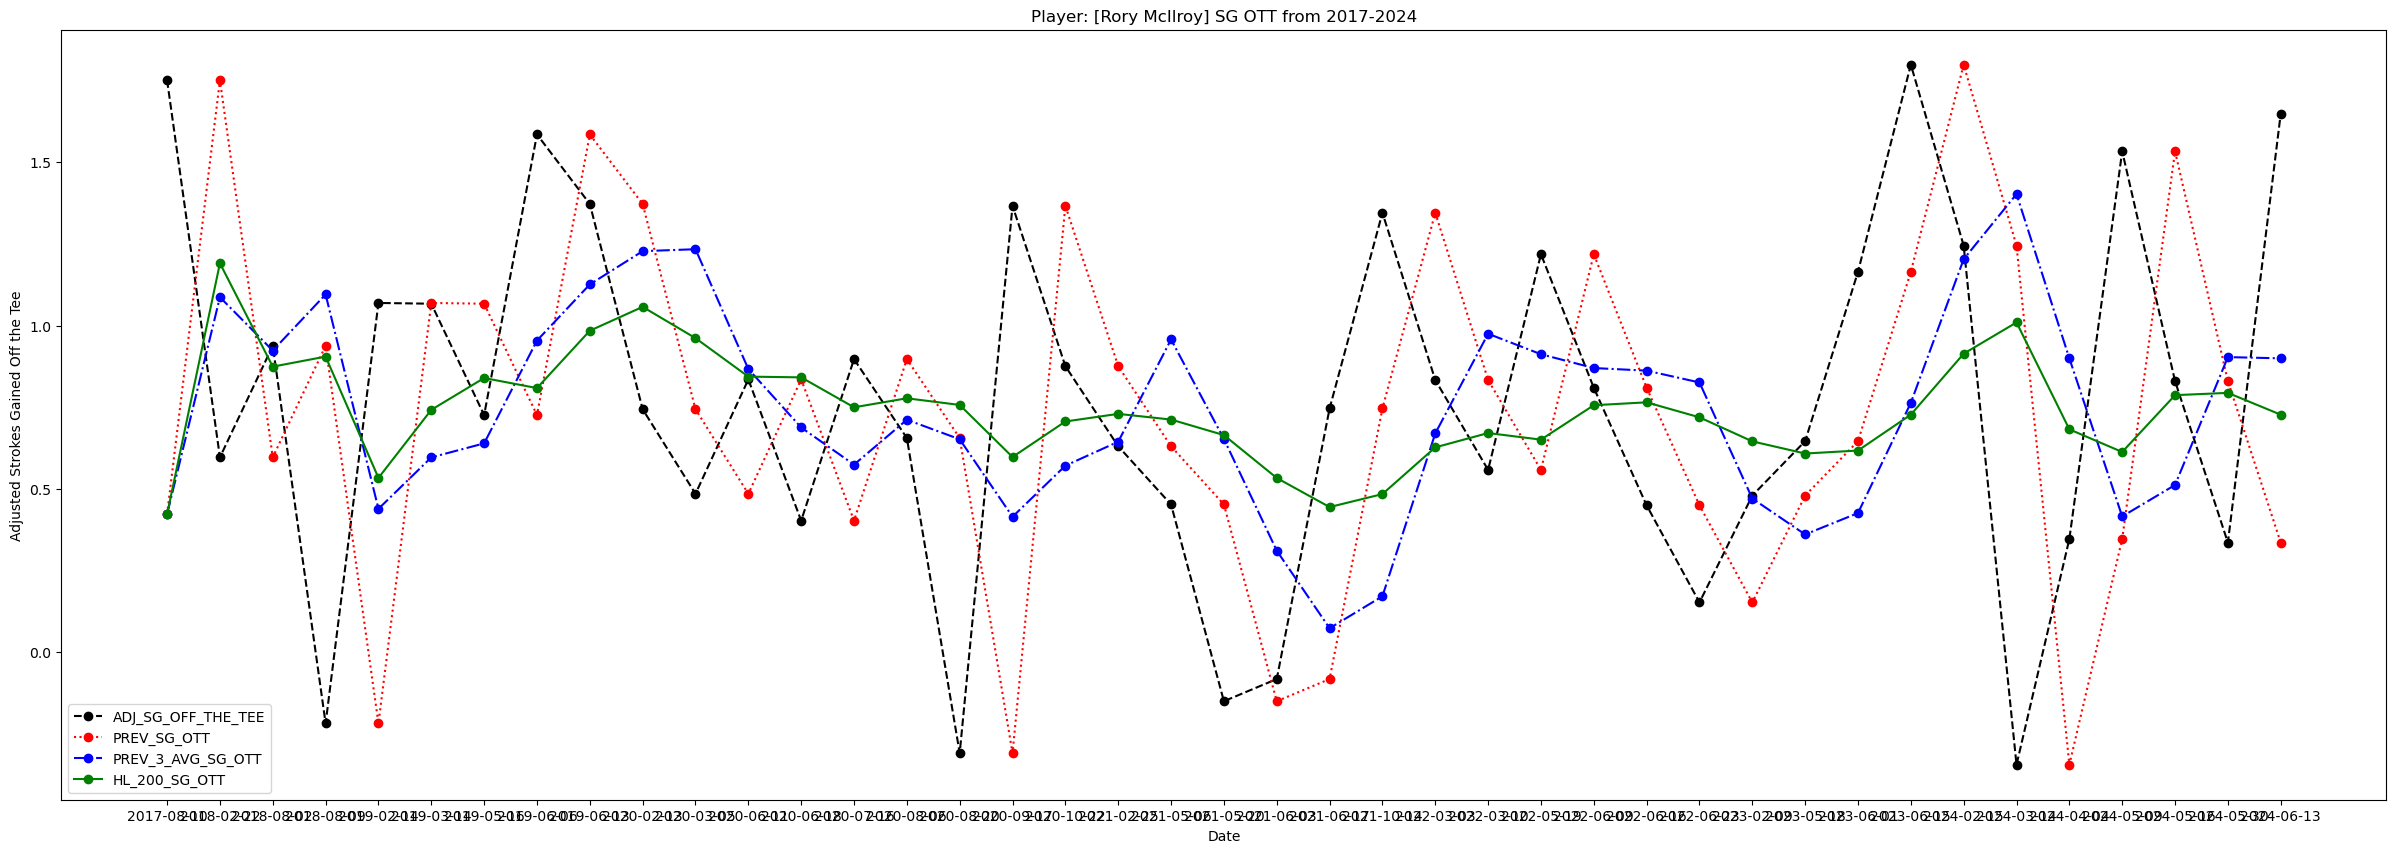

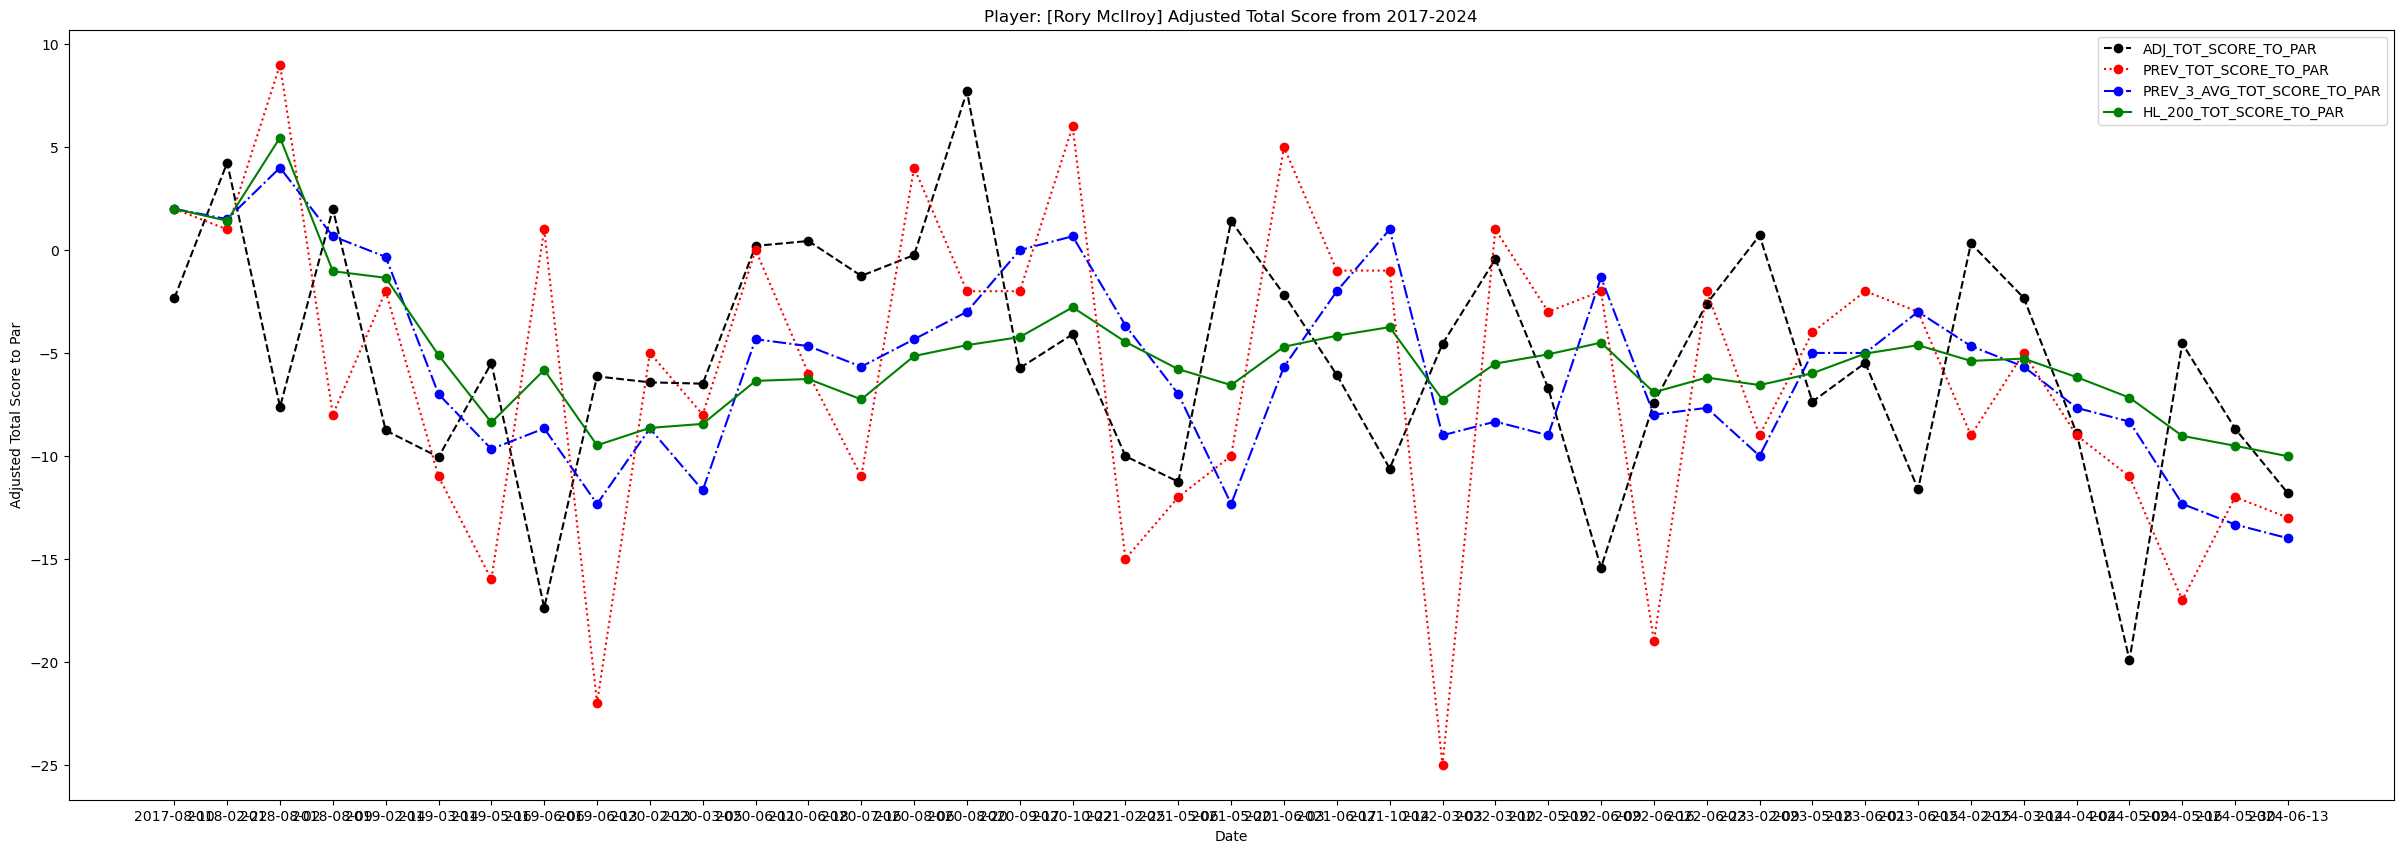

In [12]:
player_name = 'Rory McIlroy'
player_df = no_na_strokes_gained_df[['TOURNAMENT_DATE', 'PLAYER_NAME', 'ADJ_SG_PUTT', 'PREV_SG_P', 'PREV_3_AVG_SG_P', 'HL_50_SG_P', 'HL_100_SG_P', 'HL_200_SG_P']].loc[no_na_strokes_gained_df['PLAYER_NAME'] == player_name].sort_values(by='TOURNAMENT_DATE')

plt.figure(figsize=(30,10))
plt.plot(player_df['TOURNAMENT_DATE'], player_df['ADJ_SG_PUTT'], color="black", linestyle="--", marker='o', label = 'ADJ_SG_PUTT')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['PREV_SG_P'], color="red", linestyle=":", marker='o', label = 'PREV_SG_P')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['PREV_3_AVG_SG_P'], color="blue", linestyle="-.", marker='o', label = 'PREV_3_AVG_SG_P')
#plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_50_SG_P'], color="red", marker='o', label = 'HL_50_SG_P')
#plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_100_SG_P'], color="blue", marker='o', label = 'HL_100_SG_P')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_200_SG_P'], color="green", marker='o', label = 'HL_200_SG_P')

plt.title(f"Player: [{player_name}] SG Putting from 2017-2024")
plt.xlabel('Date')
plt.ylabel('Adjusted Strokes Gained Putting')
plt.legend()

player_df = no_na_strokes_gained_df[['TOURNAMENT_DATE', 'PLAYER_NAME', 'ADJ_SG_OFF_THE_TEE', 'PREV_SG_OTT', 'PREV_3_AVG_SG_OTT', 'HL_50_SG_OTT', 'HL_100_SG_OTT', 'HL_200_SG_OTT']].loc[no_na_strokes_gained_df['PLAYER_NAME'] == player_name].sort_values(by='TOURNAMENT_DATE')

plt.figure(figsize=(30,10))
plt.plot(player_df['TOURNAMENT_DATE'], player_df['ADJ_SG_OFF_THE_TEE'], color="black", linestyle="--", marker='o', label = 'ADJ_SG_OFF_THE_TEE')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['PREV_SG_OTT'], color="red", linestyle=":", marker='o', label = 'PREV_SG_OTT')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['PREV_3_AVG_SG_OTT'], color="blue", linestyle="-.", marker='o', label = 'PREV_3_AVG_SG_OTT')
#plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_50_SG_OTT'], color="red", marker='o', label = 'HL_50_SG_OTT')
#plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_100_SG_OTT'], color="blue", marker='o', label = 'HL_100_SG_OTT')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_200_SG_OTT'], color="green", marker='o', label = 'HL_200_SG_OTT')

plt.title(f"Player: [{player_name}] SG OTT from 2017-2024")
plt.xlabel('Date')
plt.ylabel('Adjusted Strokes Gained Off the Tee')
plt.legend()

player_df = no_na_strokes_gained_df[['TOURNAMENT_DATE', 'PLAYER_NAME', 'ADJ_TOT_SCORE_TO_PAR', 'PREV_TOT_SCORE_TO_PAR', 'PREV_3_AVG_TOT_SCORE_TO_PAR', 'HL_50_TOT_SCORE_TO_PAR', 'HL_100_TOT_SCORE_TO_PAR', 'HL_200_TOT_SCORE_TO_PAR']].loc[no_na_strokes_gained_df['PLAYER_NAME'] == player_name].sort_values(by='TOURNAMENT_DATE')

plt.figure(figsize=(30,10))
plt.plot(player_df['TOURNAMENT_DATE'], player_df['ADJ_TOT_SCORE_TO_PAR'], color="black", linestyle="--", marker='o', label = 'ADJ_TOT_SCORE_TO_PAR')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['PREV_TOT_SCORE_TO_PAR'], color="red", linestyle=":", marker='o', label = 'PREV_TOT_SCORE_TO_PAR')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['PREV_3_AVG_TOT_SCORE_TO_PAR'], color="blue", linestyle="-.", marker='o', label = 'PREV_3_AVG_TOT_SCORE_TO_PAR')
#plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_50_TOT_SCORE_TO_PAR'], color="red", marker='o', label = 'HL_50_TOT_SCORE_TO_PAR')
#plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_100_TOT_SCORE_TO_PAR'], color="blue", marker='o', label = 'HL_100_TOT_SCORE_TO_PAR')
plt.plot(player_df['TOURNAMENT_DATE'], player_df['HL_200_TOT_SCORE_TO_PAR'], color="green", marker='o', label = 'HL_200_TOT_SCORE_TO_PAR')

plt.title(f"Player: [{player_name}] Adjusted Total Score from 2017-2024")
plt.xlabel('Date')
plt.ylabel('Adjusted Total Score to Par')
plt.legend()

- Wanted to see how the trends of different historical aggregation techniques related to the adjusted strokes gained trend which gives the highest correlation for this statistic to the overall score